In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layerout = nn.Linear(self.hidden_dim, x_dim, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 
        z_out = self.layerout(h) 
        return z_out
    
    def eval_norm_grad(self):
        s = (self.layer_input.weight.grad*self.layer_input.weight.grad).sum()
        s+= (self.layer_input.bias.grad*self.layer_input.bias.grad).sum()
        
        s+= (self.layer_1.weight.grad*self.layer_1.weight.grad).sum()
        s+= (self.layer_1.bias.grad*self.layer_1.bias.grad).sum()
        
        s+= (self.layer_2.weight.grad*self.layer_2.weight.grad).sum()
        s+= (self.layer_2.bias.grad*self.layer_2.bias.grad).sum()
        
        s+= (self.layerout.weight.grad*self.layerout.weight.grad).sum()
        s+= (self.layerout.bias.grad*self.layerout.bias.grad).sum()
        return s
        

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.1)
    

In [5]:
N = 1000
T = 100
n = 1

x = torch.randn(N,n)
z = torch.randn(N,n)

#y = 2*torch.randn(N,n) + torch.tensor([1])

y = torch.randn(N,n)
y[:int(N/2),:] = 0.75*torch.randn(int(N/2),n) + torch.tensor([2])
y[int(N/2):,:] = 0.75*torch.randn(int(N/2),n) + torch.tensor([-2])

tf = 1
t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

X = torch.zeros(T,N,n)

X = (1-t)*x + t*y + torch.sqrt(t*(1-t))*z




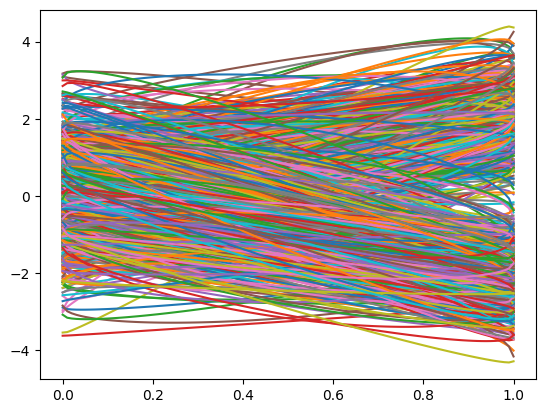

In [6]:
for i in range(N):
    plt.plot(t[:,i,0],X[:,i,0])

In [7]:
ITERS = 10000
BATCH_SIZE = 32
LR = 1e-3

f = score_nn(n,16)
init_weights(f)
f.train()
optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X[:,idx,:]
    t_train = t[:,idx,:]  
    Y_train = y[idx,:]
    f_value = f.forward(X_train,t_train) 
    loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
    optimizer_f.zero_grad()
    loss.backward()
    optimizer_f.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        f_value = f.forward(X,t) 
        loss = ((f_value-y)*(f_value-y)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/10000, loss = 2.079602718353
Iteration: 200/10000, loss = 2.075464725494
Iteration: 300/10000, loss = 2.067436456680
Iteration: 400/10000, loss = 2.066682815552
Iteration: 500/10000, loss = 2.050002336502
Iteration: 600/10000, loss = 2.037684679031
Iteration: 700/10000, loss = 2.027118206024
Iteration: 800/10000, loss = 2.015896797180
Iteration: 900/10000, loss = 2.006472587585
Iteration: 1000/10000, loss = 1.993631124496
Iteration: 1100/10000, loss = 1.980923771858
Iteration: 1200/10000, loss = 1.977632045746
Iteration: 1300/10000, loss = 1.971372604370
Iteration: 1400/10000, loss = 1.954664945602
Iteration: 1500/10000, loss = 1.943712472916
Iteration: 1600/10000, loss = 1.939379334450
Iteration: 1700/10000, loss = 1.924486875534
Iteration: 1800/10000, loss = 1.917645812035
Iteration: 1900/10000, loss = 1.912691354752
Iteration: 2000/10000, loss = 1.909922003746
Iteration: 2100/10000, loss = 1.908223390579
Iteration: 2200/10000, loss = 1.900230646133
Iteration: 2300/100

In [8]:
N = 1000
T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T


X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    X_b[i+1] = X_b[i] + (f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]-X_b[i])/(1-t[i])*dt + np.sqrt(dt)*torch.randn(N,n)

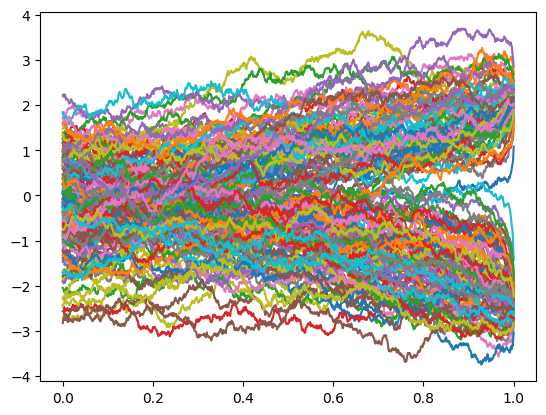

In [9]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,0].detach().numpy())

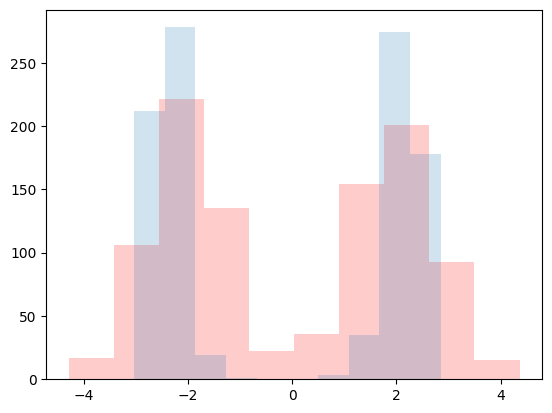

In [11]:
plt.hist(y.numpy()[:,0],alpha=0.2, color='r')
plt.hist(X_b.detach().numpy()[-1,:,0],alpha=0.2)

plt.show()